In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

# Local imports
from stability_testing import *

In [15]:
pv_dest_path = './data/hydro/existing_plants/complementarity/pv_time_series'
wind_dest_path = './data/hydro/existing_plants/complementarity/wind_time_series'
pv_filename_prefix = 'cf_pv_profile'
wind_filename_prefix = 'cf_wind_profile'

c_stab_path = './data/hydro/existing_plants/complementarity/c_stab'
pearsons_path = './data/hydro s/existing_plants/complementarity/pearson'

rep_year_df = pd.read_csv('./data/hydro/misc/ed_representative_year.csv')
years = range(2007,2014)
months = range(1,13)
pv_wind_id_df = pd.read_csv('./data/hydro/misc/master_pv_wind_ed.csv')

# build the base dataframe with the timestamps from 2012
rng = pd.date_range(f'2012-01-01 00:00:00+00:00', periods=8760, freq='1H')
base_df = pd.DataFrame()
base_df['dateTime'] = rng 

In [16]:
pv_wind_id_df.drop_duplicates(subset=['site_id'], inplace=True)
pv_wind_id_df.reset_index(inplace=True, drop=True)
pv_wind_id_df

,lat,lon,dam_name,site_id,post_csv_filename,pv_id,wind_id
0,45.158051,-67.401657,Lower Saint Croix River,1021000,./data/hydro/existing_plants/synthetic_profile...,1681,1681
1,44.786598,-71.124901,Stearns Brook-Androscoggin River,1053500,./data/hydro/existing_plants/synthetic_profile...,1178,1178
2,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,./data/hydro/existing_plants/synthetic_profile...,726,726
3,44.542599,-70.546501,Swift River-Androscoggin River,1054500,./data/hydro/existing_plants/synthetic_profile...,780,780
4,43.534500,-71.468102,Winnipesaukee River,1081000,./data/hydro/existing_plants/synthetic_profile...,1864,1864
...,...,...,...,...,...,...,...
123,40.596603,-111.423592,Lake Creek-Provo River,10155200,./data/hydro/existing_plants/synthetic_profile...,149,149
124,38.285801,-112.443298,South Creek-Beaver River,10234500,./data/hydro/existing_plants/synthetic_profile...,416,416
125,39.462898,-119.065804,Soda Lake-Carson River,10312275,./data/hydro/existing_plants/synthetic_profile...,69,69
126,39.470447,-120.104553,Little Truckee River,10344500,./data/hydro/existing_plants/synthetic_profile...,55,55


# 1. Create Montly Stability Coefficients

## Complementarity PV-Hydro

In [17]:
from pathlib import Path
from scipy.stats import pearsonr
import seaborn as sns

### Stability coefficient
missing_sites = []
df_missing = pd.DataFrame()
pv_wind_id_df.fillna(0, inplace=True)
pearsons_pv_hy = pd.DataFrame(columns=['site_id','p'])
annual_mean_p = pd.DataFrame()
annual_stab_df = pd.DataFrame(columns = ['site_id', 'lat', 'lon'])

for idx, row in pv_wind_id_df.iterrows():
    
    if row['post_csv_filename'] == 0:
        print( f"No file for site {row['site_id']} ")
        missing_sites.append(row['site_id'])
        continue
    
    if row['site_id'] not in rep_year_df.site.values:
        print(f"Site doesn't have enough data: {row['site_id']}")
        empty_data_sites.append(row['site_id'])
        query_df.loc[idx,'post_csv_filename'] = ""
        continue
        
    print(f"{idx}. Processing PV profile {row['pv_id']} and NPD {row['site_id']}, {row['post_csv_filename']}")

    solar_df = pd.read_csv(f"{pv_dest_path}/{row['pv_id']}_{pv_filename_prefix}.csv",parse_dates=True,index_col=0)

    hydro_df = pd.read_csv(row['post_csv_filename'],parse_dates=True,index_col=0)
    hydro_df.fillna(0, inplace=True)
    
    if float(hydro_df['capacity_factor'].sum()) == 0.0:
        print( f"No data in site {row['site_id']} ")
        missing_sites.append(row['site_id'])
        continue

    c_stab = []
    pearsons = []
    
    # Finds the representative year for the given stream gage
    year = str(rep_year_df['year'].loc[rep_year_df.site == row['site_id']].values[0])
    
    # Massaging the timestamps of the hydropower time-series given that we are chosing the best year in terms of data completion.
    # Here, we copy the CF into a new dataframe with the time-stamps from 2012
    tmp_hydro_df_rep_year = hydro_df.loc[year,'capacity_factor'].copy().to_frame()
    tmp_hydro_df = base_df.copy()
    tmp_hydro_df.set_index('dateTime',inplace=True)
    tmp_hydro_df['capacity_factor'] = tmp_hydro_df_rep_year.loc[year,'capacity_factor'].values
     
    tmp_solar_df = solar_df.loc['2012-01-01':'2012-12-30'].copy()

    for month in months:

        if month < 10:
            month = f'0{str(month)}'
        else:
            month = str(month)
        
        tmp_hydro_monthly_df = tmp_hydro_df.loc[f'2012-{month}','capacity_factor'].copy().to_frame()
        tmp_solar_monthly_df = tmp_solar_df.loc[f'2012-{month}'].copy()

        tmp_hydro_monthly_df.rename(columns={'capacity_factor':row['site_id']}, inplace=True)
        tmp_solar_monthly_df.rename(columns={str(row['pv_id']):row['site_id']}, inplace=True)

        # Compute complementarity metrics (PV as reference)
        _, c_stab_tmp = main_stability(tmp_solar_monthly_df, tmp_hydro_monthly_df)
        c_stab_tmp.rename(columns={row['site_id']:month}, inplace=True)

        c_stab.append(c_stab_tmp)
         
        corr, _ = pearsonr(tmp_solar_monthly_df[row['site_id']].values, tmp_hydro_monthly_df[row['site_id']].values)
        pearsons.append(corr)
    
    # ***************************************** Stability Coefficient *****************************************
    c_stab_df = pd.concat(c_stab, axis=1)

    annual_mean = c_stab_df.mean(axis=0)

    annual_stab_df.loc[idx,'site_id'] = row['site_id']
    annual_stab_df.loc[idx,'pv_id'] = row['pv_id']
    annual_stab_df.loc[idx,'lat'] = row['lat']
    annual_stab_df.loc[idx,'lon'] = row['lon']
    annual_stab_df.loc[idx,months] = annual_mean.values
    
    # ***************************************** Pearsons Coefficient *****************************************
    p_series = pd.Series(pearsons)

    annual_mean_p.loc[idx,'site_id'] = row['site_id']
    annual_mean_p.loc[idx,'pv_id'] = row['pv_id']
    annual_mean_p.loc[idx,'lat'] = row['lat']
    annual_mean_p.loc[idx,'lon'] = row['lon']
    annual_mean_p.loc[idx,months] = p_series.values

annual_stab_df.to_csv(f"{c_stab_path}/rep_year_MONTHLY_ed_stab_pv_hydro.csv")
annual_mean_p.to_csv(f"{pearsons_path}/rep_year_MONTHLY_ed_pearsons_pv_hydro.csv")

0. Processing PV profile 1681 and NPD 1021000, ./data/hydro/existing_plants/synthetic_profiles/ed_1021000_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1. Processing PV profile 1178 and NPD 1053500, ./data/hydro/existing_plants/synthetic_profiles/ed_1053500_2013_synthetic.csv
2. Processing PV profile 726 and NPD 1054000, ./data/hydro/existing_plants/synthetic_profiles/ed_1054000_2013_synthetic.csv
3. Processing PV profile 780 and NPD 1054500, ./data/hydro/existing_plants/synthetic_profiles/ed_1054500_2014_synthetic.csv
No data in site 1054500 
4. Processing PV profile 1864 and NPD 1081000, ./data/hydro/existing_plants/synthetic_profiles/ed_1081000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


5. Processing PV profile 1772 and NPD 1082000, ./data/hydro/existing_plants/synthetic_profiles/ed_1082000_2017_synthetic.csv
No data in site 1082000 
6. Processing PV profile 1180 and NPD 1091500, ./data/hydro/existing_plants/synthetic_profiles/ed_1091500_2019_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


7. Processing PV profile 1982 and NPD 1094000, ./data/hydro/existing_plants/synthetic_profiles/ed_1094000_2019_synthetic.csv
8. Processing PV profile 1562 and NPD 1096500, ./data/hydro/existing_plants/synthetic_profiles/ed_1096500_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


9. Processing PV profile 1720 and NPD 1100000, ./data/hydro/existing_plants/synthetic_profiles/ed_1100000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


10. Processing PV profile 1863 and NPD 1105876, ./data/hydro/existing_plants/synthetic_profiles/ed_1105876_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


11. Processing PV profile 1725 and NPD 1113895, ./data/hydro/existing_plants/synthetic_profiles/ed_1113895_2013_synthetic.csv
No data in site 1113895 
12. Processing PV profile 1832 and NPD 1125100, ./data/hydro/existing_plants/synthetic_profiles/ed_1125100_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


13. Processing PV profile 1973 and NPD 1135500, ./data/hydro/existing_plants/synthetic_profiles/ed_1135500_2014_synthetic.csv
No data in site 1135500 
14. Processing PV profile 256 and NPD 1151500, ./data/hydro/existing_plants/synthetic_profiles/ed_1151500_2017_synthetic.csv
No data in site 1151500 
15. Processing PV profile 1840 and NPD 1152010, ./data/hydro/existing_plants/synthetic_profiles/ed_1152010_2018_synthetic.csv
No data in site 1152010 
16. Processing PV profile 1355 and NPD 1152500, ./data/hydro/existing_plants/synthetic_profiles/ed_1152500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


17. Processing PV profile 1992 and NPD 1162000, ./data/hydro/existing_plants/synthetic_profiles/ed_1162000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


18. Processing PV profile 1844 and NPD 1166500, ./data/hydro/existing_plants/synthetic_profiles/ed_1166500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


19. Processing PV profile 766 and NPD 1170000, ./data/hydro/existing_plants/synthetic_profiles/ed_1170000_2010_synthetic.csv
No data in site 1170000 
20. Processing PV profile 534 and NPD 1172010, ./data/hydro/existing_plants/synthetic_profiles/ed_1172010_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


21. Processing PV profile 1347 and NPD 1177000, ./data/hydro/existing_plants/synthetic_profiles/ed_1177000_2010_synthetic.csv
No data in site 1177000 
22. Processing PV profile 816 and NPD 1327750, ./data/hydro/existing_plants/synthetic_profiles/ed_1327750_2013_synthetic.csv
23. Processing PV profile 1271 and NPD 1346000, ./data/hydro/existing_plants/synthetic_profiles/ed_1346000_2014_synthetic.csv
No data in site 1346000 
24. Processing PV profile 1201 and NPD 1347000, ./data/hydro/existing_plants/synthetic_profiles/ed_1347000_2014_synthetic.csv
25. Processing PV profile 1218 and NPD 1348000, ./data/hydro/existing_plants/synthetic_profiles/ed_1348000_2010_synthetic.csv
No data in site 1348000 
26. Processing PV profile 1037 and NPD 1350180, ./data/hydro/existing_plants/synthetic_profiles/ed_1350180_2013_synthetic.csv
No data in site 1350180 
27. Processing PV profile 1147 and NPD 1367500, ./data/hydro/existing_plants/synthetic_profiles/ed_1367500_2013_synthetic.csv
No data in site 136

/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


34. Processing PV profile 778 and NPD 2153551, ./data/hydro/existing_plants/synthetic_profiles/ed_2153551_2016_synthetic.csv
No data in site 2153551 
35. Processing PV profile 1624 and NPD 2163500, ./data/hydro/existing_plants/synthetic_profiles/ed_2163500_2014_synthetic.csv
No data in site 2163500 
36. Processing PV profile 438 and NPD 2167000, ./data/hydro/existing_plants/synthetic_profiles/ed_2167000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


37. Processing PV profile 792 and NPD 2181350, ./data/hydro/existing_plants/synthetic_profiles/ed_2181350_2015_synthetic.csv
No data in site 2181350 
38. Processing PV profile 792 and NPD 2181580, ./data/hydro/existing_plants/synthetic_profiles/ed_2181580_2010_synthetic.csv
No data in site 2181580 
39. Processing PV profile 1370 and NPD 2207335, ./data/hydro/existing_plants/synthetic_profiles/ed_2207335_2010_synthetic.csv
No data in site 2207335 
40. Processing PV profile 705 and NPD 2335815, ./data/hydro/existing_plants/synthetic_profiles/ed_2335815_2014_synthetic.csv
41. Processing PV profile 2108 and NPD 2364500, ./data/hydro/existing_plants/synthetic_profiles/ed_2364500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


42. Processing PV profile 294 and NPD 3209000, ./data/hydro/existing_plants/synthetic_profiles/ed_3209000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


43. Processing PV profile 1146 and NPD 3221000, ./data/hydro/existing_plants/synthetic_profiles/ed_3221000_2015_synthetic.csv
No data in site 3221000 
44. Processing PV profile 1597 and NPD 3287000, ./data/hydro/existing_plants/synthetic_profiles/ed_3287000_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


45. Processing PV profile 1387 and NPD 3453000, ./data/hydro/existing_plants/synthetic_profiles/ed_3453000_2011_synthetic.csv
No data in site 3453000 
46. Processing PV profile 993 and NPD 3503000, ./data/hydro/existing_plants/synthetic_profiles/ed_3503000_2011_synthetic.csv
No data in site 3503000 
47. Processing PV profile 984 and NPD 4044003, ./data/hydro/existing_plants/synthetic_profiles/ed_4044003_2019_synthetic.csv
No data in site 4044003 
48. Processing PV profile 1507 and NPD 4044724, ./data/hydro/existing_plants/synthetic_profiles/ed_4044724_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


49. Processing PV profile 1504 and NPD 4058100, ./data/hydro/existing_plants/synthetic_profiles/ed_4058100_2013_synthetic.csv
No data in site 4058100 
50. Processing PV profile 569 and NPD 4062000, ./data/hydro/existing_plants/synthetic_profiles/ed_4062000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


51. Processing PV profile 520 and NPD 4066003, ./data/hydro/existing_plants/synthetic_profiles/ed_4066003_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


52. Processing PV profile 796 and NPD 4066030, ./data/hydro/existing_plants/synthetic_profiles/ed_4066030_2015_synthetic.csv
53. Processing PV profile 977 and NPD 4069500, ./data/hydro/existing_plants/synthetic_profiles/ed_4069500_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


54. Processing PV profile 522 and NPD 4071765, ./data/hydro/existing_plants/synthetic_profiles/ed_4071765_2016_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


55. Processing PV profile 975 and NPD 4101225, ./data/hydro/existing_plants/synthetic_profiles/ed_4101225_2019_synthetic.csv
No data in site 4101225 
56. Processing PV profile 413 and NPD 4108660, ./data/hydro/existing_plants/synthetic_profiles/ed_4108660_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


57. Processing PV profile 1490 and NPD 4113000, ./data/hydro/existing_plants/synthetic_profiles/ed_4113000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


58. Processing PV profile 883 and NPD 4122001, ./data/hydro/existing_plants/synthetic_profiles/ed_4122001_2018_synthetic.csv
59. Processing PV profile 990 and NPD 4124200, ./data/hydro/existing_plants/synthetic_profiles/ed_4124200_2015_synthetic.csv
60. Processing PV profile 976 and NPD 4125550, ./data/hydro/existing_plants/synthetic_profiles/ed_4125550_2013_synthetic.csv
61. Processing PV profile 864 and NPD 4136500, ./data/hydro/existing_plants/synthetic_profiles/ed_4136500_2013_synthetic.csv
62. Processing PV profile 863 and NPD 4137005, ./data/hydro/existing_plants/synthetic_profiles/ed_4137005_2018_synthetic.csv
63. Processing PV profile 866 and NPD 4137500, ./data/hydro/existing_plants/synthetic_profiles/ed_4137500_2013_synthetic.csv
64. Processing PV profile 1349 and NPD 4191500, ./data/hydro/existing_plants/synthetic_profiles/ed_4191500_2013_synthetic.csv
No data in site 4191500 
65. Processing PV profile 978 and NPD 4231600, ./data/hydro/existing_plants/synthetic_profiles/ed_4

/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


66. Processing PV profile 854 and NPD 4232730, ./data/hydro/existing_plants/synthetic_profiles/ed_4232730_2014_synthetic.csv
67. Processing PV profile 1775 and NPD 4235440, ./data/hydro/existing_plants/synthetic_profiles/ed_4235440_2013_synthetic.csv
68. Processing PV profile 1482 and NPD 4249000, ./data/hydro/existing_plants/synthetic_profiles/ed_4249000_2013_synthetic.csv
69. Processing PV profile 1525 and NPD 4250200, ./data/hydro/existing_plants/synthetic_profiles/ed_4250200_2011_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


70. Processing PV profile 1015 and NPD 4258000, ./data/hydro/existing_plants/synthetic_profiles/ed_4258000_2018_synthetic.csv
71. Processing PV profile 1059 and NPD 4262000, ./data/hydro/existing_plants/synthetic_profiles/ed_4262000_2013_synthetic.csv
72. Processing PV profile 1076 and NPD 4273500, ./data/hydro/existing_plants/synthetic_profiles/ed_4273500_2018_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


73. Processing PV profile 861 and NPD 4282000, ./data/hydro/existing_plants/synthetic_profiles/ed_4282000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


74. Processing PV profile 1270 and NPD 4285500, ./data/hydro/existing_plants/synthetic_profiles/ed_4285500_2017_synthetic.csv
75. Processing PV profile 915 and NPD 4290500, ./data/hydro/existing_plants/synthetic_profiles/ed_4290500_2010_synthetic.csv
No data in site 4290500 
76. Processing PV profile 677 and NPD 4292500, ./data/hydro/existing_plants/synthetic_profiles/ed_4292500_2010_synthetic.csv
No data in site 4292500 
77. Processing PV profile 2173 and NPD 4293000, ./data/hydro/existing_plants/synthetic_profiles/ed_4293000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


78. Processing PV profile 944 and NPD 4294000, ./data/hydro/existing_plants/synthetic_profiles/ed_4294000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


79. Processing PV profile 1275 and NPD 5129515, ./data/hydro/existing_plants/synthetic_profiles/ed_5129515_2016_synthetic.csv
80. Processing PV profile 1602 and NPD 5200510, ./data/hydro/existing_plants/synthetic_profiles/ed_5200510_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


81. Processing PV profile 931 and NPD 5242300, ./data/hydro/existing_plants/synthetic_profiles/ed_5242300_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


82. Processing PV profile 870 and NPD 5247500, ./data/hydro/existing_plants/synthetic_profiles/ed_5247500_2018_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


83. Processing PV profile 379 and NPD 5267000, ./data/hydro/existing_plants/synthetic_profiles/ed_5267000_2011_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


84. Processing PV profile 1764 and NPD 5270700, ./data/hydro/existing_plants/synthetic_profiles/ed_5270700_2018_synthetic.csv
85. Processing PV profile 1123 and NPD 5341752, ./data/hydro/existing_plants/synthetic_profiles/ed_5341752_2013_synthetic.csv
No data in site 5341752 
86. Processing PV profile 1479 and NPD 5342000, ./data/hydro/existing_plants/synthetic_profiles/ed_5342000_2013_synthetic.csv
No data in site 5342000 
87. Processing PV profile 1334 and NPD 5355092, ./data/hydro/existing_plants/synthetic_profiles/ed_5355092_2018_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


88. Processing PV profile 1871 and NPD 5383075, ./data/hydro/existing_plants/synthetic_profiles/ed_5383075_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


89. Processing PV profile 1409 and NPD 5421740, ./data/hydro/existing_plants/synthetic_profiles/ed_5421740_2017_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


90. Processing PV profile 862 and NPD 5442300, ./data/hydro/existing_plants/synthetic_profiles/ed_5442300_2010_synthetic.csv
No data in site 5442300 
91. Processing PV profile 1366 and NPD 5443500, ./data/hydro/existing_plants/synthetic_profiles/ed_5443500_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


92. Processing PV profile 171 and NPD 5507800, ./data/hydro/existing_plants/synthetic_profiles/ed_5507800_2016_synthetic.csv
93. Processing PV profile 737 and NPD 6204070, ./data/hydro/existing_plants/synthetic_profiles/ed_6204070_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


94. Processing PV profile 788 and NPD 6714500, ./data/hydro/existing_plants/synthetic_profiles/ed_6714500_2019_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


95. Processing PV profile 18 and NPD 6741510, ./data/hydro/existing_plants/synthetic_profiles/ed_6741510_2012_synthetic.csv
No data in site 6741510 
96. Processing PV profile 436 and NPD 6796000, ./data/hydro/existing_plants/synthetic_profiles/ed_6796000_2015_synthetic.csv
97. Processing PV profile 388 and NPD 6926000, ./data/hydro/existing_plants/synthetic_profiles/ed_6926000_2018_synthetic.csv
98. Processing PV profile 103 and NPD 7083710, ./data/hydro/existing_plants/synthetic_profiles/ed_7083710_2010_synthetic.csv
No data in site 7083710 
99. Processing PV profile 923 and NPD 7191500, ./data/hydro/existing_plants/synthetic_profiles/ed_7191500_2016_synthetic.csv
100. Processing PV profile 305 and NPD 7263450, ./data/hydro/existing_plants/synthetic_profiles/ed_7263450_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


101. Processing PV profile 275 and NPD 8053000, ./data/hydro/existing_plants/synthetic_profiles/ed_8053000_2010_synthetic.csv
No data in site 8053000 
102. Processing PV profile 274 and NPD 8167800, ./data/hydro/existing_plants/synthetic_profiles/ed_8167800_2017_synthetic.csv
103. Processing PV profile 1628 and NPD 8169845, ./data/hydro/existing_plants/synthetic_profiles/ed_8169845_2019_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


104. Processing PV profile 1151 and NPD 8173900, ./data/hydro/existing_plants/synthetic_profiles/ed_8173900_2018_synthetic.csv
No data in site 8173900 
105. Processing PV profile 16 and NPD 8361000, ./data/hydro/existing_plants/synthetic_profiles/ed_8361000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


106. Processing PV profile 1247 and NPD 9050700, ./data/hydro/existing_plants/synthetic_profiles/ed_9050700_2016_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


107. Processing PV profile 25 and NPD 9057500, ./data/hydro/existing_plants/synthetic_profiles/ed_9057500_2016_synthetic.csv
108. Processing PV profile 1741 and NPD 9079450, ./data/hydro/existing_plants/synthetic_profiles/ed_9079450_2017_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


109. Processing PV profile 101 and NPD 9080400, ./data/hydro/existing_plants/synthetic_profiles/ed_9080400_2017_synthetic.csv
110. Processing PV profile 13 and NPD 9128000, ./data/hydro/existing_plants/synthetic_profiles/ed_9128000_2016_synthetic.csv
111. Processing PV profile 20 and NPD 9211200, ./data/hydro/existing_plants/synthetic_profiles/ed_9211200_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


112. Processing PV profile 2048 and NPD 9237500, ./data/hydro/existing_plants/synthetic_profiles/ed_9237500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


113. Processing PV profile 97 and NPD 9353800, ./data/hydro/existing_plants/synthetic_profiles/ed_9353800_2014_synthetic.csv
No data in site 9353800 
114. Processing PV profile 22 and NPD 9380000, ./data/hydro/existing_plants/synthetic_profiles/ed_9380000_2015_synthetic.csv
115. Processing PV profile 1447 and NPD 9410100, ./data/hydro/existing_plants/synthetic_profiles/ed_9410100_2016_synthetic.csv
No data in site 9410100 
116. Processing PV profile 14 and NPD 9423000, ./data/hydro/existing_plants/synthetic_profiles/ed_9423000_2012_synthetic.csv
117. Processing PV profile 47 and NPD 9427520, ./data/hydro/existing_plants/synthetic_profiles/ed_9427520_2017_synthetic.csv
118. Processing PV profile 1231 and NPD 10113500, ./data/hydro/existing_plants/synthetic_profiles/ed_10113500_2012_synthetic.csv
119. Processing PV profile 102 and NPD 10132000, ./data/hydro/existing_plants/synthetic_profiles/ed_10132000_2016_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


120. Processing PV profile 79 and NPD 10137000, ./data/hydro/existing_plants/synthetic_profiles/ed_10137000_2016_synthetic.csv
No data in site 10137000 
121. Processing PV profile 108 and NPD 10140100, ./data/hydro/existing_plants/synthetic_profiles/ed_10140100_2012_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


122. Processing PV profile 108 and NPD 10140700, ./data/hydro/existing_plants/synthetic_profiles/ed_10140700_2012_synthetic.csv
No data in site 10140700 
123. Processing PV profile 149 and NPD 10155200, ./data/hydro/existing_plants/synthetic_profiles/ed_10155200_2010_synthetic.csv
124. Processing PV profile 416 and NPD 10234500, ./data/hydro/existing_plants/synthetic_profiles/ed_10234500_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


125. Processing PV profile 69 and NPD 10312275, ./data/hydro/existing_plants/synthetic_profiles/ed_10312275_2012_synthetic.csv
126. Processing PV profile 55 and NPD 10344500, ./data/hydro/existing_plants/synthetic_profiles/ed_10344500_2013_synthetic.csv
127. Processing PV profile 270 and NPD 11465200, ./data/hydro/existing_plants/synthetic_profiles/ed_11465200_2012_synthetic.csv
No data in site 11465200 


In [18]:
annual_stab_df.head()

,site_id,lat,lon,pv_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1021000,45.158051,-67.401657,1681.0,0.111315,0.121815,0.389943,0.231025,0.000000,0.082066,0.000000,0.000000,0.000907,0.069317,0.399679,0.665155
1,1053500,44.786598,-71.124901,1178.0,0.695029,0.574872,0.525999,0.427788,0.266639,0.373242,0.390259,0.266257,0.172629,0.147807,0.029257,0.025853
2,1054000,44.456947,-71.186066,726.0,0.678020,0.547525,0.483297,0.426130,0.300871,0.379022,0.349203,0.091458,0.069642,0.012153,0.090301,0.089799
4,1081000,43.5345,-71.468102,1864.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.017890,0.000000,0.000000,0.091670,0.213818,0.109637,0.000000
6,1091500,43.018501,-71.5979,1180.0,0.460039,0.258758,0.440494,0.809120,0.316938,0.064169,0.018267,0.000000,0.000000,0.004713,0.181008,0.454367


## Complementarity PV-Wind

In [19]:
from pathlib import Path
from scipy.stats import pearsonr

### Stability coefficient
missing_sites = []
df_missing = pd.DataFrame()

pv_wind_id_df.fillna(0, inplace=True)

annual_mean_p = pd.DataFrame()
pearsons_wind_hy = pd.DataFrame(columns=['site_id','p'])

annual_stab_df = pd.DataFrame(columns = ['site_id', 'lat', 'lon'])

for idx, row in pv_wind_id_df.iterrows():
    
    if row['post_csv_filename'] == 0:
        print( f"No file for site {row['site_id']} ")
        missing_sites.append(row['site_id'])
        continue
    
    if row['site_id'] not in rep_year_df.site.values:
        print(f"Site doesn't have enough data: {row['site_id']}")
        empty_data_sites.append(row['site_id'])
        query_df.loc[idx,'post_csv_filename'] = ""
        continue

    print(f"{idx}. Processing Wind profile {row['wind_id']} and NPD {row['site_id']}, {row['post_csv_filename']}")

    wind_df = pd.read_csv(f"{wind_dest_path}/{row['wind_id']}_{wind_filename_prefix}.csv",parse_dates=True,index_col=0)

    hydro_df = pd.read_csv(row['post_csv_filename'],parse_dates=True,index_col=0)
    hydro_df.fillna(0, inplace=True)

    if float(hydro_df['capacity_factor'].sum()) == 0.0:
        print( f"No data in site {row['site_id']} ")
        missing_sites.append(row['site_id'])
        continue

    cf_mix = []
    c_stab = []
    pearsons = []
    
    # Finds the representative year for the given stream gage
    year = str(rep_year_df['year'].loc[rep_year_df.site == row['site_id']].values[0])
    
    # Massaging the timestamps of the hydropower time-series given that we are chosing the best year in terms of data completion.
    # Here, we copy the CF into a new dataframe with the time-stamps from 2012
    tmp_hydro_df_rep_year = hydro_df.loc[year,'capacity_factor'].copy().to_frame()
    tmp_hydro_df = base_df.copy()
    tmp_hydro_df.set_index('dateTime',inplace=True)
    tmp_hydro_df['capacity_factor'] = tmp_hydro_df_rep_year.loc[year,'capacity_factor'].values
    
    tmp_wind_df = wind_df.loc['2012-01-01':'2012-12-30'].copy()

    
    for month in months:

        if month < 10:
            month = f'0{str(month)}'
        else:
            month = str(month)
        
        tmp_hydro_monthly_df = tmp_hydro_df.loc[f'2012-{month}','capacity_factor'].copy().to_frame()
        tmp_wind_monthly_df = tmp_wind_df.loc[f'2012-{month}'].copy()

        tmp_hydro_monthly_df.rename(columns={'capacity_factor':row['site_id']}, inplace=True)
        tmp_wind_monthly_df.rename(columns={str(row['wind_id']):row['site_id']}, inplace=True)

        # Compute complementarity metrics (PV as reference)
        _, c_stab_tmp = main_stability(tmp_wind_monthly_df, tmp_hydro_monthly_df)
        c_stab_tmp.rename(columns={row['site_id']:month}, inplace=True)

        c_stab.append(c_stab_tmp)
        
        corr, _ = pearsonr(tmp_wind_monthly_df[row['site_id']].values, tmp_hydro_monthly_df[row['site_id']].values)
        pearsons.append(corr)

    c_stab_df = pd.concat(c_stab, axis=1)
    
    annual_mean = c_stab_df.mean(axis=0)

    annual_stab_df.loc[idx,'site_id'] = row['site_id']
    annual_stab_df.loc[idx,'pv_id'] = row['pv_id']
    annual_stab_df.loc[idx,'lat'] = row['lat']
    annual_stab_df.loc[idx,'lon'] = row['lon']
    annual_stab_df.loc[idx,months] = annual_mean.values
    
    # ***************************************** Pearsons Coefficient *****************************************
    p_series = pd.Series(pearsons)

    annual_mean_p.loc[idx,'site_id'] = row['site_id']
    annual_mean_p.loc[idx,'pv_id'] = row['pv_id']
    annual_mean_p.loc[idx,'lat'] = row['lat']
    annual_mean_p.loc[idx,'lon'] = row['lon']
    annual_mean_p.loc[idx,months] = p_series.values
    #break

annual_stab_df.to_csv(f"{c_stab_path}/rep_year_MONTHLY_ed_stab_wind_hydro.csv")
annual_mean_p.to_csv(f"{pearsons_path}/rep_year_MONTHLY_ed_pearsons_wind_hydro.csv")

0. Processing Wind profile 1681 and NPD 1021000, ./data/hydro/existing_plants/synthetic_profiles/ed_1021000_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1. Processing Wind profile 1178 and NPD 1053500, ./data/hydro/existing_plants/synthetic_profiles/ed_1053500_2013_synthetic.csv
2. Processing Wind profile 726 and NPD 1054000, ./data/hydro/existing_plants/synthetic_profiles/ed_1054000_2013_synthetic.csv
3. Processing Wind profile 780 and NPD 1054500, ./data/hydro/existing_plants/synthetic_profiles/ed_1054500_2014_synthetic.csv
No data in site 1054500 
4. Processing Wind profile 1864 and NPD 1081000, ./data/hydro/existing_plants/synthetic_profiles/ed_1081000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


5. Processing Wind profile 1772 and NPD 1082000, ./data/hydro/existing_plants/synthetic_profiles/ed_1082000_2017_synthetic.csv
No data in site 1082000 
6. Processing Wind profile 1180 and NPD 1091500, ./data/hydro/existing_plants/synthetic_profiles/ed_1091500_2019_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


7. Processing Wind profile 1982 and NPD 1094000, ./data/hydro/existing_plants/synthetic_profiles/ed_1094000_2019_synthetic.csv
8. Processing Wind profile 1562 and NPD 1096500, ./data/hydro/existing_plants/synthetic_profiles/ed_1096500_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


9. Processing Wind profile 1720 and NPD 1100000, ./data/hydro/existing_plants/synthetic_profiles/ed_1100000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


10. Processing Wind profile 1863 and NPD 1105876, ./data/hydro/existing_plants/synthetic_profiles/ed_1105876_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


11. Processing Wind profile 1725 and NPD 1113895, ./data/hydro/existing_plants/synthetic_profiles/ed_1113895_2013_synthetic.csv
No data in site 1113895 
12. Processing Wind profile 1832 and NPD 1125100, ./data/hydro/existing_plants/synthetic_profiles/ed_1125100_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


13. Processing Wind profile 1973 and NPD 1135500, ./data/hydro/existing_plants/synthetic_profiles/ed_1135500_2014_synthetic.csv
No data in site 1135500 
14. Processing Wind profile 256 and NPD 1151500, ./data/hydro/existing_plants/synthetic_profiles/ed_1151500_2017_synthetic.csv
No data in site 1151500 
15. Processing Wind profile 1840 and NPD 1152010, ./data/hydro/existing_plants/synthetic_profiles/ed_1152010_2018_synthetic.csv
No data in site 1152010 
16. Processing Wind profile 1355 and NPD 1152500, ./data/hydro/existing_plants/synthetic_profiles/ed_1152500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


17. Processing Wind profile 1992 and NPD 1162000, ./data/hydro/existing_plants/synthetic_profiles/ed_1162000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


18. Processing Wind profile 1844 and NPD 1166500, ./data/hydro/existing_plants/synthetic_profiles/ed_1166500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


19. Processing Wind profile 766 and NPD 1170000, ./data/hydro/existing_plants/synthetic_profiles/ed_1170000_2010_synthetic.csv
No data in site 1170000 
20. Processing Wind profile 534 and NPD 1172010, ./data/hydro/existing_plants/synthetic_profiles/ed_1172010_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


21. Processing Wind profile 1347 and NPD 1177000, ./data/hydro/existing_plants/synthetic_profiles/ed_1177000_2010_synthetic.csv
No data in site 1177000 
22. Processing Wind profile 816 and NPD 1327750, ./data/hydro/existing_plants/synthetic_profiles/ed_1327750_2013_synthetic.csv
23. Processing Wind profile 1271 and NPD 1346000, ./data/hydro/existing_plants/synthetic_profiles/ed_1346000_2014_synthetic.csv
No data in site 1346000 
24. Processing Wind profile 1201 and NPD 1347000, ./data/hydro/existing_plants/synthetic_profiles/ed_1347000_2014_synthetic.csv
25. Processing Wind profile 1218 and NPD 1348000, ./data/hydro/existing_plants/synthetic_profiles/ed_1348000_2010_synthetic.csv
No data in site 1348000 
26. Processing Wind profile 1037 and NPD 1350180, ./data/hydro/existing_plants/synthetic_profiles/ed_1350180_2013_synthetic.csv
No data in site 1350180 
27. Processing Wind profile 1147 and NPD 1367500, ./data/hydro/existing_plants/synthetic_profiles/ed_1367500_2013_synthetic.csv
No da

/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


34. Processing Wind profile 778 and NPD 2153551, ./data/hydro/existing_plants/synthetic_profiles/ed_2153551_2016_synthetic.csv
No data in site 2153551 
35. Processing Wind profile 1624 and NPD 2163500, ./data/hydro/existing_plants/synthetic_profiles/ed_2163500_2014_synthetic.csv
No data in site 2163500 
36. Processing Wind profile 438 and NPD 2167000, ./data/hydro/existing_plants/synthetic_profiles/ed_2167000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


37. Processing Wind profile 792 and NPD 2181350, ./data/hydro/existing_plants/synthetic_profiles/ed_2181350_2015_synthetic.csv
No data in site 2181350 
38. Processing Wind profile 792 and NPD 2181580, ./data/hydro/existing_plants/synthetic_profiles/ed_2181580_2010_synthetic.csv
No data in site 2181580 
39. Processing Wind profile 1370 and NPD 2207335, ./data/hydro/existing_plants/synthetic_profiles/ed_2207335_2010_synthetic.csv
No data in site 2207335 
40. Processing Wind profile 705 and NPD 2335815, ./data/hydro/existing_plants/synthetic_profiles/ed_2335815_2014_synthetic.csv
41. Processing Wind profile 2108 and NPD 2364500, ./data/hydro/existing_plants/synthetic_profiles/ed_2364500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


42. Processing Wind profile 294 and NPD 3209000, ./data/hydro/existing_plants/synthetic_profiles/ed_3209000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


43. Processing Wind profile 1146 and NPD 3221000, ./data/hydro/existing_plants/synthetic_profiles/ed_3221000_2015_synthetic.csv
No data in site 3221000 
44. Processing Wind profile 1597 and NPD 3287000, ./data/hydro/existing_plants/synthetic_profiles/ed_3287000_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


45. Processing Wind profile 1387 and NPD 3453000, ./data/hydro/existing_plants/synthetic_profiles/ed_3453000_2011_synthetic.csv
No data in site 3453000 
46. Processing Wind profile 993 and NPD 3503000, ./data/hydro/existing_plants/synthetic_profiles/ed_3503000_2011_synthetic.csv
No data in site 3503000 
47. Processing Wind profile 984 and NPD 4044003, ./data/hydro/existing_plants/synthetic_profiles/ed_4044003_2019_synthetic.csv
No data in site 4044003 
48. Processing Wind profile 1507 and NPD 4044724, ./data/hydro/existing_plants/synthetic_profiles/ed_4044724_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


49. Processing Wind profile 1504 and NPD 4058100, ./data/hydro/existing_plants/synthetic_profiles/ed_4058100_2013_synthetic.csv
No data in site 4058100 
50. Processing Wind profile 569 and NPD 4062000, ./data/hydro/existing_plants/synthetic_profiles/ed_4062000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


51. Processing Wind profile 520 and NPD 4066003, ./data/hydro/existing_plants/synthetic_profiles/ed_4066003_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


52. Processing Wind profile 796 and NPD 4066030, ./data/hydro/existing_plants/synthetic_profiles/ed_4066030_2015_synthetic.csv
53. Processing Wind profile 977 and NPD 4069500, ./data/hydro/existing_plants/synthetic_profiles/ed_4069500_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


54. Processing Wind profile 522 and NPD 4071765, ./data/hydro/existing_plants/synthetic_profiles/ed_4071765_2016_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


55. Processing Wind profile 975 and NPD 4101225, ./data/hydro/existing_plants/synthetic_profiles/ed_4101225_2019_synthetic.csv
No data in site 4101225 
56. Processing Wind profile 413 and NPD 4108660, ./data/hydro/existing_plants/synthetic_profiles/ed_4108660_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


57. Processing Wind profile 1490 and NPD 4113000, ./data/hydro/existing_plants/synthetic_profiles/ed_4113000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


58. Processing Wind profile 883 and NPD 4122001, ./data/hydro/existing_plants/synthetic_profiles/ed_4122001_2018_synthetic.csv
59. Processing Wind profile 990 and NPD 4124200, ./data/hydro/existing_plants/synthetic_profiles/ed_4124200_2015_synthetic.csv
60. Processing Wind profile 976 and NPD 4125550, ./data/hydro/existing_plants/synthetic_profiles/ed_4125550_2013_synthetic.csv
61. Processing Wind profile 864 and NPD 4136500, ./data/hydro/existing_plants/synthetic_profiles/ed_4136500_2013_synthetic.csv
62. Processing Wind profile 863 and NPD 4137005, ./data/hydro/existing_plants/synthetic_profiles/ed_4137005_2018_synthetic.csv
63. Processing Wind profile 866 and NPD 4137500, ./data/hydro/existing_plants/synthetic_profiles/ed_4137500_2013_synthetic.csv
64. Processing Wind profile 1349 and NPD 4191500, ./data/hydro/existing_plants/synthetic_profiles/ed_4191500_2013_synthetic.csv
No data in site 4191500 
65. Processing Wind profile 978 and NPD 4231600, ./data/hydro/existing_plants/synthet

/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


66. Processing Wind profile 854 and NPD 4232730, ./data/hydro/existing_plants/synthetic_profiles/ed_4232730_2014_synthetic.csv
67. Processing Wind profile 1775 and NPD 4235440, ./data/hydro/existing_plants/synthetic_profiles/ed_4235440_2013_synthetic.csv
68. Processing Wind profile 1482 and NPD 4249000, ./data/hydro/existing_plants/synthetic_profiles/ed_4249000_2013_synthetic.csv
69. Processing Wind profile 1525 and NPD 4250200, ./data/hydro/existing_plants/synthetic_profiles/ed_4250200_2011_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


70. Processing Wind profile 1015 and NPD 4258000, ./data/hydro/existing_plants/synthetic_profiles/ed_4258000_2018_synthetic.csv
71. Processing Wind profile 1059 and NPD 4262000, ./data/hydro/existing_plants/synthetic_profiles/ed_4262000_2013_synthetic.csv
72. Processing Wind profile 1076 and NPD 4273500, ./data/hydro/existing_plants/synthetic_profiles/ed_4273500_2018_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


73. Processing Wind profile 861 and NPD 4282000, ./data/hydro/existing_plants/synthetic_profiles/ed_4282000_2014_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


74. Processing Wind profile 1270 and NPD 4285500, ./data/hydro/existing_plants/synthetic_profiles/ed_4285500_2017_synthetic.csv
75. Processing Wind profile 915 and NPD 4290500, ./data/hydro/existing_plants/synthetic_profiles/ed_4290500_2010_synthetic.csv
No data in site 4290500 
76. Processing Wind profile 677 and NPD 4292500, ./data/hydro/existing_plants/synthetic_profiles/ed_4292500_2010_synthetic.csv
No data in site 4292500 
77. Processing Wind profile 2173 and NPD 4293000, ./data/hydro/existing_plants/synthetic_profiles/ed_4293000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


78. Processing Wind profile 944 and NPD 4294000, ./data/hydro/existing_plants/synthetic_profiles/ed_4294000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


79. Processing Wind profile 1275 and NPD 5129515, ./data/hydro/existing_plants/synthetic_profiles/ed_5129515_2016_synthetic.csv
80. Processing Wind profile 1602 and NPD 5200510, ./data/hydro/existing_plants/synthetic_profiles/ed_5200510_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


81. Processing Wind profile 931 and NPD 5242300, ./data/hydro/existing_plants/synthetic_profiles/ed_5242300_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


82. Processing Wind profile 870 and NPD 5247500, ./data/hydro/existing_plants/synthetic_profiles/ed_5247500_2018_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


83. Processing Wind profile 379 and NPD 5267000, ./data/hydro/existing_plants/synthetic_profiles/ed_5267000_2011_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


84. Processing Wind profile 1764 and NPD 5270700, ./data/hydro/existing_plants/synthetic_profiles/ed_5270700_2018_synthetic.csv
85. Processing Wind profile 1123 and NPD 5341752, ./data/hydro/existing_plants/synthetic_profiles/ed_5341752_2013_synthetic.csv
No data in site 5341752 
86. Processing Wind profile 1479 and NPD 5342000, ./data/hydro/existing_plants/synthetic_profiles/ed_5342000_2013_synthetic.csv
No data in site 5342000 
87. Processing Wind profile 1334 and NPD 5355092, ./data/hydro/existing_plants/synthetic_profiles/ed_5355092_2018_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


88. Processing Wind profile 1871 and NPD 5383075, ./data/hydro/existing_plants/synthetic_profiles/ed_5383075_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


89. Processing Wind profile 1409 and NPD 5421740, ./data/hydro/existing_plants/synthetic_profiles/ed_5421740_2017_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


90. Processing Wind profile 862 and NPD 5442300, ./data/hydro/existing_plants/synthetic_profiles/ed_5442300_2010_synthetic.csv
No data in site 5442300 
91. Processing Wind profile 1366 and NPD 5443500, ./data/hydro/existing_plants/synthetic_profiles/ed_5443500_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


92. Processing Wind profile 171 and NPD 5507800, ./data/hydro/existing_plants/synthetic_profiles/ed_5507800_2016_synthetic.csv
93. Processing Wind profile 737 and NPD 6204070, ./data/hydro/existing_plants/synthetic_profiles/ed_6204070_2013_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


94. Processing Wind profile 788 and NPD 6714500, ./data/hydro/existing_plants/synthetic_profiles/ed_6714500_2019_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


95. Processing Wind profile 18 and NPD 6741510, ./data/hydro/existing_plants/synthetic_profiles/ed_6741510_2012_synthetic.csv
No data in site 6741510 
96. Processing Wind profile 436 and NPD 6796000, ./data/hydro/existing_plants/synthetic_profiles/ed_6796000_2015_synthetic.csv
97. Processing Wind profile 388 and NPD 6926000, ./data/hydro/existing_plants/synthetic_profiles/ed_6926000_2018_synthetic.csv
98. Processing Wind profile 103 and NPD 7083710, ./data/hydro/existing_plants/synthetic_profiles/ed_7083710_2010_synthetic.csv
No data in site 7083710 
99. Processing Wind profile 923 and NPD 7191500, ./data/hydro/existing_plants/synthetic_profiles/ed_7191500_2016_synthetic.csv
100. Processing Wind profile 305 and NPD 7263450, ./data/hydro/existing_plants/synthetic_profiles/ed_7263450_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


101. Processing Wind profile 275 and NPD 8053000, ./data/hydro/existing_plants/synthetic_profiles/ed_8053000_2010_synthetic.csv
No data in site 8053000 
102. Processing Wind profile 274 and NPD 8167800, ./data/hydro/existing_plants/synthetic_profiles/ed_8167800_2017_synthetic.csv
103. Processing Wind profile 1628 and NPD 8169845, ./data/hydro/existing_plants/synthetic_profiles/ed_8169845_2019_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


104. Processing Wind profile 1151 and NPD 8173900, ./data/hydro/existing_plants/synthetic_profiles/ed_8173900_2018_synthetic.csv
No data in site 8173900 
105. Processing Wind profile 16 and NPD 8361000, ./data/hydro/existing_plants/synthetic_profiles/ed_8361000_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


106. Processing Wind profile 1247 and NPD 9050700, ./data/hydro/existing_plants/synthetic_profiles/ed_9050700_2016_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


107. Processing Wind profile 25 and NPD 9057500, ./data/hydro/existing_plants/synthetic_profiles/ed_9057500_2016_synthetic.csv
108. Processing Wind profile 1741 and NPD 9079450, ./data/hydro/existing_plants/synthetic_profiles/ed_9079450_2017_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


109. Processing Wind profile 101 and NPD 9080400, ./data/hydro/existing_plants/synthetic_profiles/ed_9080400_2017_synthetic.csv
110. Processing Wind profile 13 and NPD 9128000, ./data/hydro/existing_plants/synthetic_profiles/ed_9128000_2016_synthetic.csv
111. Processing Wind profile 20 and NPD 9211200, ./data/hydro/existing_plants/synthetic_profiles/ed_9211200_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


112. Processing Wind profile 2048 and NPD 9237500, ./data/hydro/existing_plants/synthetic_profiles/ed_9237500_2010_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


113. Processing Wind profile 97 and NPD 9353800, ./data/hydro/existing_plants/synthetic_profiles/ed_9353800_2014_synthetic.csv
No data in site 9353800 
114. Processing Wind profile 22 and NPD 9380000, ./data/hydro/existing_plants/synthetic_profiles/ed_9380000_2015_synthetic.csv
115. Processing Wind profile 1447 and NPD 9410100, ./data/hydro/existing_plants/synthetic_profiles/ed_9410100_2016_synthetic.csv
No data in site 9410100 
116. Processing Wind profile 14 and NPD 9423000, ./data/hydro/existing_plants/synthetic_profiles/ed_9423000_2012_synthetic.csv
117. Processing Wind profile 47 and NPD 9427520, ./data/hydro/existing_plants/synthetic_profiles/ed_9427520_2017_synthetic.csv
118. Processing Wind profile 422 and NPD 10113500, ./data/hydro/existing_plants/synthetic_profiles/ed_10113500_2012_synthetic.csv
119. Processing Wind profile 102 and NPD 10132000, ./data/hydro/existing_plants/synthetic_profiles/ed_10132000_2016_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


120. Processing Wind profile 79 and NPD 10137000, ./data/hydro/existing_plants/synthetic_profiles/ed_10137000_2016_synthetic.csv
No data in site 10137000 
121. Processing Wind profile 108 and NPD 10140100, ./data/hydro/existing_plants/synthetic_profiles/ed_10140100_2012_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


122. Processing Wind profile 108 and NPD 10140700, ./data/hydro/existing_plants/synthetic_profiles/ed_10140700_2012_synthetic.csv
No data in site 10140700 
123. Processing Wind profile 149 and NPD 10155200, ./data/hydro/existing_plants/synthetic_profiles/ed_10155200_2010_synthetic.csv
124. Processing Wind profile 416 and NPD 10234500, ./data/hydro/existing_plants/synthetic_profiles/ed_10234500_2015_synthetic.csv


/opt/anaconda3/envs/flexpower/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


125. Processing Wind profile 69 and NPD 10312275, ./data/hydro/existing_plants/synthetic_profiles/ed_10312275_2012_synthetic.csv
126. Processing Wind profile 55 and NPD 10344500, ./data/hydro/existing_plants/synthetic_profiles/ed_10344500_2013_synthetic.csv
127. Processing Wind profile 270 and NPD 11465200, ./data/hydro/existing_plants/synthetic_profiles/ed_11465200_2012_synthetic.csv
No data in site 11465200 


# Relationship plots

## Ranking the sites based on their annual stability coefficient

### ED PV-Hydro

In [4]:
pv_hydro_annual_stab_df = pd.read_csv(f"{c_stab_path}/rep_year_MONTHLY_ed_stab_pv_hydro.csv")
pv_hydro_annual_stab_df

# Cleaning up the dataframe
c_stab_pv_hydro_df = pd.DataFrame()
c_stab_pv_hydro_df['site_id'] = pv_hydro_annual_stab_df['site_id']
c_stab_pv_hydro_df[['1','2','3','4','5','6','7','8','9','10','11','12']] = pv_hydro_annual_stab_df[['1','2','3','4','5','6','7','8','9','10','11','12']].copy()

# Computing the yearly mean across the months
rank_c_stab_pv_hydro_df = pd.DataFrame()
rank_c_stab_pv_hydro_df['site_id'] = c_stab_pv_hydro_df['site_id']
rank_c_stab_pv_hydro_df['c_stab_mean'] = c_stab_pv_hydro_df[['1','2','3','4','5','6','7','8','9','10','11','12']].mean(axis=1)

In [5]:
c_stab_pv_hydro_df

,site_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1021000,0.111315,0.121815,0.389943,0.231025,0.000000,0.082066,0.000000,0.000000,0.000907,0.069317,0.399679,0.665155
1,1053500,0.695029,0.574872,0.525999,0.427788,0.266639,0.373242,0.390259,0.266257,0.172629,0.147807,0.029257,0.025853
2,1054000,0.678020,0.547525,0.483297,0.426130,0.300871,0.379022,0.349203,0.091458,0.069642,0.012153,0.090301,0.089799
3,1054000,0.678020,0.547525,0.483297,0.426130,0.300871,0.379022,0.349203,0.091458,0.069642,0.012153,0.090301,0.089799
4,1054000,0.678020,0.547525,0.483297,0.426130,0.300871,0.379022,0.349203,0.091458,0.069642,0.012153,0.090301,0.089799
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,10234500,0.000000,0.000000,0.099957,0.356879,0.750105,0.732500,0.775142,0.122181,0.000000,0.004903,0.000000,0.000000
125,10234500,0.000000,0.000000,0.099957,0.356879,0.750105,0.732500,0.775142,0.122181,0.000000,0.004903,0.000000,0.000000
126,10234500,0.000000,0.000000,0.099957,0.356879,0.750105,0.732500,0.775142,0.122181,0.000000,0.004903,0.000000,0.000000
127,10312275,0.887419,0.795199,0.676321,0.788091,0.750640,0.679605,0.750154,0.684688,0.692395,0.540910,0.585841,0.579382


In [6]:
rank_c_stab_pv_hydro_df.sort_values(by='c_stab_mean',ascending=True)

,site_id,c_stab_mean
5,1081000,0.036085
45,4069500,0.048326
105,7191500,0.094877
98,5421740,0.129008
33,2025500,0.144242
...,...,...
88,4293000,0.825321
53,4125550,0.827883
55,4137005,0.829373
40,4062000,0.842149


In [7]:
# Calculating the deciles for the yearly mean
rank_c_stab_pv_hydro_df['decile_rank']= pd.qcut(rank_c_stab_pv_hydro_df['c_stab_mean'], 
                                         q = 10, labels = False)
rank_c_stab_pv_hydro_df.head()

,site_id,c_stab_mean,decile_rank
0,1021000,0.172602,0
1,1053500,0.324636,4
2,1054000,0.293118,4
3,1054000,0.293118,4
4,1054000,0.293118,4


In [8]:
rank_c_stab_pv_hydro_df.to_csv('rank.csv')

In [9]:
coo_df = pv_wind_id_df[['lat','lon','site_id','dam_name']]
input_df = pd.read_csv('../data/misc/flexpower_existing_hydro_w_NID_join.csv')
input_df_capacity = input_df[['stream_gauge_id','CH_MW']].copy()


coo_df=coo_df.merge(input_df_capacity, left_on='site_id', right_on='stream_gauge_id', how='outer')
coo_df.head()

,lat,lon,site_id,dam_name,stream_gauge_id,CH_MW
0,45.158051,-67.401657,1021000.0,Lower Saint Croix River,1021000,18.5
1,44.786598,-71.124901,1053500.0,Stearns Brook-Androscoggin River,1053500,3.0
2,44.456947,-71.186066,1054000.0,Stearns Brook-Androscoggin River,1054000,15.0
3,44.456947,-71.186066,1054000.0,Stearns Brook-Androscoggin River,1054000,3.0
4,44.456947,-71.186066,1054000.0,Stearns Brook-Androscoggin River,1054000,7.9


In [10]:
rank_c_stab_pv_hydro_df=rank_c_stab_pv_hydro_df.merge(coo_df, left_on='site_id', right_on='site_id', how='outer')

In [11]:
rank_c_stab_pv_hydro_df.head()

,site_id,c_stab_mean,decile_rank,lat,lon,dam_name,stream_gauge_id,CH_MW
0,1021000.0,0.172602,0.0,45.158051,-67.401657,Lower Saint Croix River,1021000,18.5
1,1053500.0,0.324636,4.0,44.786598,-71.124901,Stearns Brook-Androscoggin River,1053500,3.0
2,1054000.0,0.293118,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,15.0
3,1054000.0,0.293118,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,3.0
4,1054000.0,0.293118,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,7.9


In [12]:
rank_c_stab_pv_hydro_df.to_csv('../data/existing_plants/complementarity/ed_pv_hydro_c_stab_decile_rank.csv')
rank_c_stab_pv_hydro_df.dropna(inplace=True)
rank_c_stab_pv_hydro_df

,site_id,c_stab_mean,decile_rank,lat,lon,dam_name,stream_gauge_id,CH_MW
0,1021000.0,0.172602,0.0,45.158051,-67.401657,Lower Saint Croix River,1021000,18.500
1,1053500.0,0.324636,4.0,44.786598,-71.124901,Stearns Brook-Androscoggin River,1053500,3.000
2,1054000.0,0.293118,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,15.000
3,1054000.0,0.293118,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,3.000
4,1054000.0,0.293118,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,7.900
...,...,...,...,...,...,...,...,...
1524,10234500.0,0.236806,2.0,38.269699,-112.480499,South Creek-Beaver River,10234500,0.275
1525,10234500.0,0.236806,2.0,38.269699,-112.480499,South Creek-Beaver River,10234500,0.625
1526,10312275.0,0.700887,8.0,39.462898,-119.065803,Soda Lake-Carson River,10312275,4.000
1527,10312275.0,0.700887,8.0,39.462898,-119.065803,Soda Lake-Carson River,10312275,1.800


In [13]:
how_many_on_each_decile = {}

for dec in rank_c_stab_pv_hydro_df.decile_rank.unique():
    how_many_on_each_decile[str(dec)] = rank_c_stab_pv_hydro_df.loc[rank_c_stab_pv_hydro_df.decile_rank == dec].count()


In [14]:
import random

def pre_process_for_rank_plotting(rank_df, monthly_df):
    plotting_sites = []
    
    for dec in rank_df.decile_rank.unique():
        #print(dec)
        # Obtain the best site for each rank (mean)
        site = rank_df.loc[rank_df.decile_rank == dec].sort_values(by='c_stab_mean',ascending=False).site_id.values[0]
        print(f"Best site {site}, {rank_df.dam_name.loc[rank_df.site_id == site].values[0]} for decile {dec} with stability coefficient {rank_df.c_stab_mean.loc[rank_df.site_id == site].values}")
        tmp_tup = (site,dec)
        plotting_sites.append(tmp_tup)
       
    # Create an empty dataframe to re-organize the data for plotting line ranking
    no_of_Rows = len(pv_hydro_annual_stab_df)
    plotting_df = pd.DataFrame(index=range(no_of_Rows))
    plotting_df['site_id'] = 0
    plotting_df['Month'] = 0
    plotting_df['c_stab'] = 0
    plotting_df['rank'] = 0
    
    plot_df_list = []
    months = range(1,13)
    for month in months:
        #print(month)
        for idx, row in monthly_df.iterrows():
            #print(row)
            plotting_df.loc[idx,'site_id'] = row['site_id']
            plotting_df.loc[idx,'Month'] = month
            plotting_df.loc[idx,'c_stab'] = row[str(month)]
            plotting_df.loc[idx,'decile_rank'] = rank_df.decile_rank.loc[rank_df.site_id == row['site_id']].values[0]

        plot_df_list.append(plotting_df.copy())
    
    # This is the dataframe with all the sites and ranks, reformatted for line plot
    c_stab_plotting_data = pd.concat(plot_df_list)
    
    # This is the dataset that will contain only the top site for each rank. In this case, 10 sites
    #c_stab_min_rank_plot = pd.DataFrame(index=len(tmp_tup))
    tmp_list = []
    for item in plotting_sites:
        tmp_df = c_stab_plotting_data.loc[plotting_df.site_id == item[0]].copy()
        tmp_df['rank'] = item[1]
        tmp_list.append(tmp_df)
    c_stab_min_rank_plot = pd.concat(tmp_list)
    
    return c_stab_plotting_data, c_stab_min_rank_plot
        
        

In [15]:
plot_df, min_plot_df = pre_process_for_rank_plotting(rank_c_stab_pv_hydro_df, c_stab_pv_hydro_df)

Best site 5443500.0, Deer Creek-Rock River for decile 0.0 with stability coefficient [0.20454953]
Best site 1327750.0, Snook Kill-Hudson River for decile 4.0 with stability coefficient [0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334 0.3987334
 0.3987334 0.3987334 0.3987334 0.3

In [16]:
min_plot_df

,site_id,Month,c_stab,rank,decile_rank
99,5443500.0,1,0.000038,0.0,0.0
99,5443500.0,2,0.118758,0.0,0.0
99,5443500.0,3,0.453736,0.0,0.0
99,5443500.0,4,0.673900,0.0,0.0
99,5443500.0,5,0.516543,0.0,0.0
...,...,...,...,...,...
127,10312275.0,8,0.684688,8.0,8.0
127,10312275.0,9,0.692395,8.0,8.0
127,10312275.0,10,0.540910,8.0,8.0
127,10312275.0,11,0.585841,8.0,8.0


In [17]:
min_plot_df = min_plot_df.astype({"site_id": str})
min_plot_df.reset_index(inplace=True)
min_plot_df.sort_values(by='rank', ascending=False,inplace=True)

In [18]:
import seaborn as sns

sns.set()
rel = sns.relplot(
    data=min_plot_df,
    x="Month", y="c_stab",
    kind="line",hue="site_id",size="rank",
    height=7.5, aspect=1.5, facet_kws=dict(sharex=False),legend="full"
).set(title="The best NPDs for each decile in PV-Hydro complementarity")
#rel.fig.suptitle("The best NPDs for each decile")

1. take the average across the months for each site
2. rank the table based on the value of the average
3. bin this data to obtain "top" percentile (e.g. 20th)
4. assign a color to each bin (e.g. top 20th yellow,...). Use the same color scale that NREL uses
5. Use this in a map

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

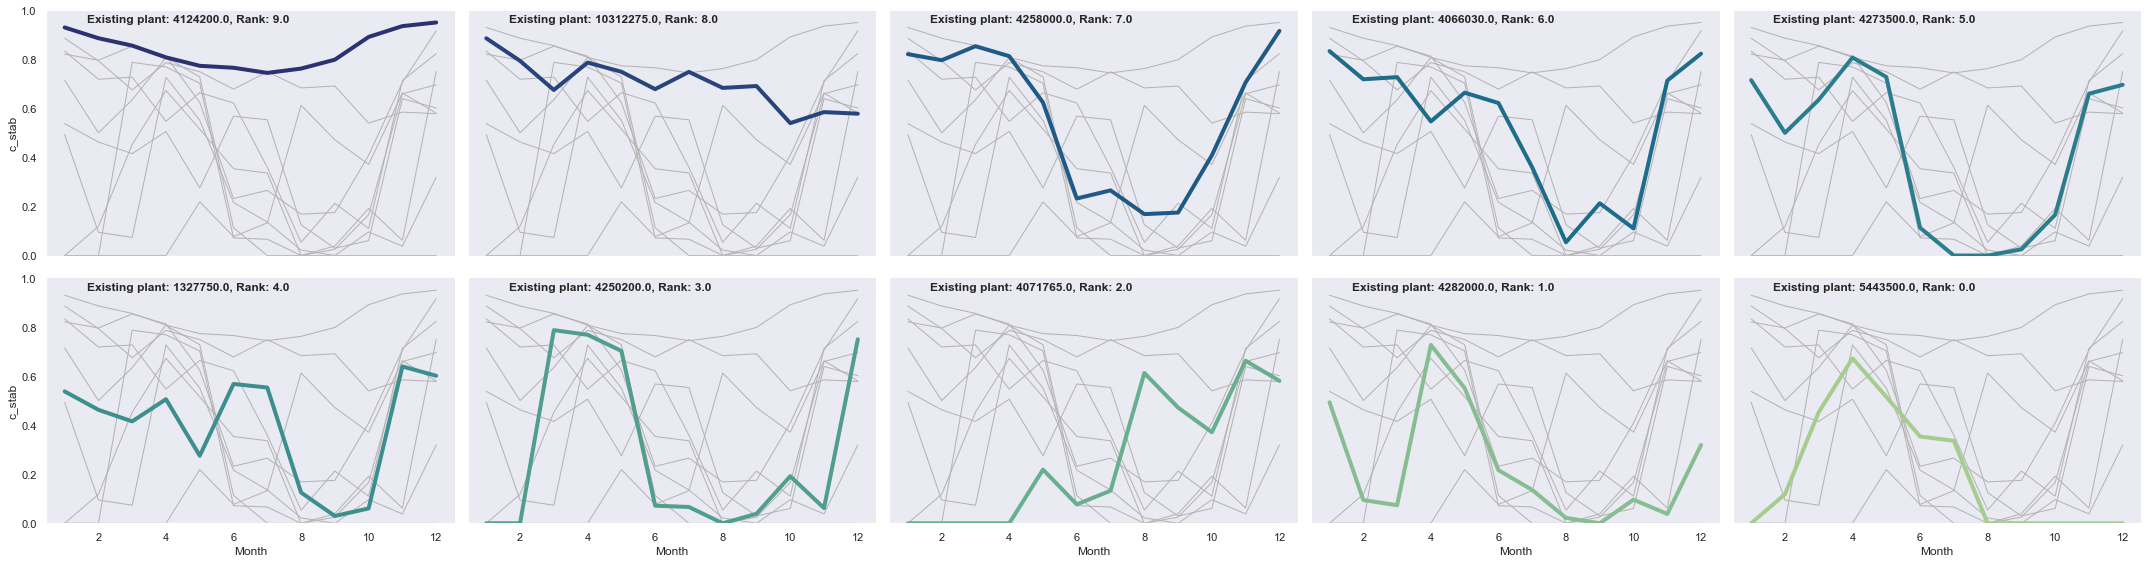

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set()
sns.set_theme(style="dark")
#sns.set_context("talk")
# Plot each year's time series in its own facet
g = sns.relplot(
    data=min_plot_df,
    x="Month", y="c_stab", col="site_id", hue="rank",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for site, ax in g.axes_dict.items():
    
    rank = min_plot_df["rank"].loc[min_plot_df.site_id == site].values[0]
    # Add the title as an annotation within the plot
    ax.text(.1, .95, f"Existing plant: {site}, Rank: {rank}", transform=ax.transAxes, fontweight="bold")
    
    # Add the title as an annotation within the plot
    
    #ax.text(.8, .65, f"Rank: {rank}", transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=min_plot_df, x="Month", y="c_stab", units="site_id",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.set_ylim([0,1])

# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])
# Tweak the supporting aspects of the plot
g.set_titles("")
#g.set_axis_labels("Months", "Stability Coefficient")
#g.fig.suptitle("The best NPDs for each decile")
g.tight_layout()
plt.savefig("ed_ranked_pv_hydro_deciles.eps")

### Existing Wind-Hydro

In [45]:
wind_hydro_annual_stab_df = pd.read_csv(f"{c_stab_path}/rep_year_MONTHLY_ed_stab_wind_hydro.csv")
wind_hydro_annual_stab_df

# Cleaning up the dataframe
c_stab_wind_hydro_df = pd.DataFrame()
c_stab_wind_hydro_df['site_id'] = wind_hydro_annual_stab_df['site_id']
c_stab_wind_hydro_df[['1','2','3','4','5','6','7','8','9','10','11','12']] = wind_hydro_annual_stab_df[['1','2','3','4','5','6','7','8','9','10','11','12']].copy()

# Computing the yearly mean across the months
rank_c_stab_wind_hydro_df = pd.DataFrame()
rank_c_stab_wind_hydro_df['site_id'] = c_stab_wind_hydro_df['site_id']
rank_c_stab_wind_hydro_df['c_stab_mean'] = c_stab_wind_hydro_df[['1','2','3','4','5','6','7','8','9','10','11','12']].mean(axis=1)

In [49]:
rank_c_stab_wind_hydro_df.sort_values(by='c_stab_mean',ascending=True)

# Calculating the deciles for the yearly mean
rank_c_stab_wind_hydro_df['decile_rank']= pd.qcut(rank_c_stab_wind_hydro_df['c_stab_mean'], 
                                         q = 10, labels = False)

coo_df = pv_wind_id_df[['lat','lon','site_id','dam_name']]
input_df = pd.read_csv('../data/misc/flexpower_existing_hydro_w_NID_join.csv')
input_df_capacity = input_df[['stream_gauge_id','CH_MW']].copy()


coo_df=coo_df.merge(input_df_capacity, left_on='site_id', right_on='stream_gauge_id', how='outer')
coo_df.head()



rank_c_stab_wind_hydro_df=rank_c_stab_wind_hydro_df.merge(coo_df, left_on='site_id', right_on='site_id', how='outer')

rank_c_stab_wind_hydro_df.to_csv('../data/existing_plants/complementarity/ed_wind_hydro_c_stab_decile_rank.csv')
rank_c_stab_wind_hydro_df.dropna(inplace=True)
rank_c_stab_wind_hydro_df


,site_id,c_stab_mean,decile_rank,lat,lon,dam_name,stream_gauge_id,CH_MW
0,1021000.0,-0.030459,2.0,45.158051,-67.401657,Lower Saint Croix River,1021000,18.500
1,1053500.0,0.257481,5.0,44.786598,-71.124901,Stearns Brook-Androscoggin River,1053500,3.000
2,1054000.0,0.200432,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,15.000
3,1054000.0,0.200432,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,3.000
4,1054000.0,0.200432,4.0,44.456947,-71.186066,Stearns Brook-Androscoggin River,1054000,7.900
...,...,...,...,...,...,...,...,...
1524,10234500.0,0.222161,4.0,38.269699,-112.480499,South Creek-Beaver River,10234500,0.275
1525,10234500.0,0.222161,4.0,38.269699,-112.480499,South Creek-Beaver River,10234500,0.625
1526,10312275.0,0.697962,9.0,39.462898,-119.065803,Soda Lake-Carson River,10312275,4.000
1527,10312275.0,0.697962,9.0,39.462898,-119.065803,Soda Lake-Carson River,10312275,1.800


In [50]:
plot_wind_hydro_df, min_wind_hydro_plot_df = pre_process_for_rank_plotting(rank_c_stab_wind_hydro_df, c_stab_wind_hydro_df)
min_plot_df = min_wind_hydro_plot_df.astype({"site_id": str})
min_plot_df.reset_index(inplace=True)

Best site 1096500.0, Nissitissit River-Nashua River for decile 2.0 with stability coefficient [0.11415216]
Best site 1327750.0, Snook Kill-Hudson River for decile 5.0 with stability coefficient [0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441 0.26243441
 0

In [51]:
min_wind_hydro_plot_df

,site_id,Month,c_stab,rank,decile_rank
10,1096500.0,1,0.103529,2.0,2.0
10,1096500.0,2,-0.031686,2.0,2.0
10,1096500.0,3,0.136984,2.0,2.0
10,1096500.0,4,0.468703,2.0,2.0
10,1096500.0,5,0.189435,2.0,2.0
...,...,...,...,...,...
117,9380000.0,8,0.815285,9.0,9.0
117,9380000.0,9,0.834202,9.0,9.0
117,9380000.0,10,0.790048,9.0,9.0
117,9380000.0,11,0.852755,9.0,9.0


In [57]:
min_wind_hydro_plot_df = min_wind_hydro_plot_df.astype({"site_id": str})
min_wind_hydro_plot_df.reset_index(inplace=True, drop=True)
min_wind_hydro_plot_df.sort_values(by='rank', ascending=False,inplace=True)

In [52]:
#coo_df = pv_wind_id_df[['lat','lon','site_id']]
#input_df = pd.read_csv('combined_hydro_stream_gauge_full2.csv')
#input_df_capacity = input_df[['stream_gauge_id','potential_cap_mw']].copy()

#coo_df=coo_df.merge(input_df_capacity, left_on='site_id', right_on='stream_gauge_id', how='outer')
#coo_df.head()

In [53]:
#rank_c_stab_wind_hydro_df=rank_c_stab_wind_hydro_df.merge(coo_df, left_on='site_id', right_on='site_id', how='outer')
#rank_c_stab_wind_hydro_df.head()

In [54]:
rank_c_stab_wind_hydro_df.to_csv('../data/npd/complementarity/ed_wind_hydro_c_stab_decile_rank.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

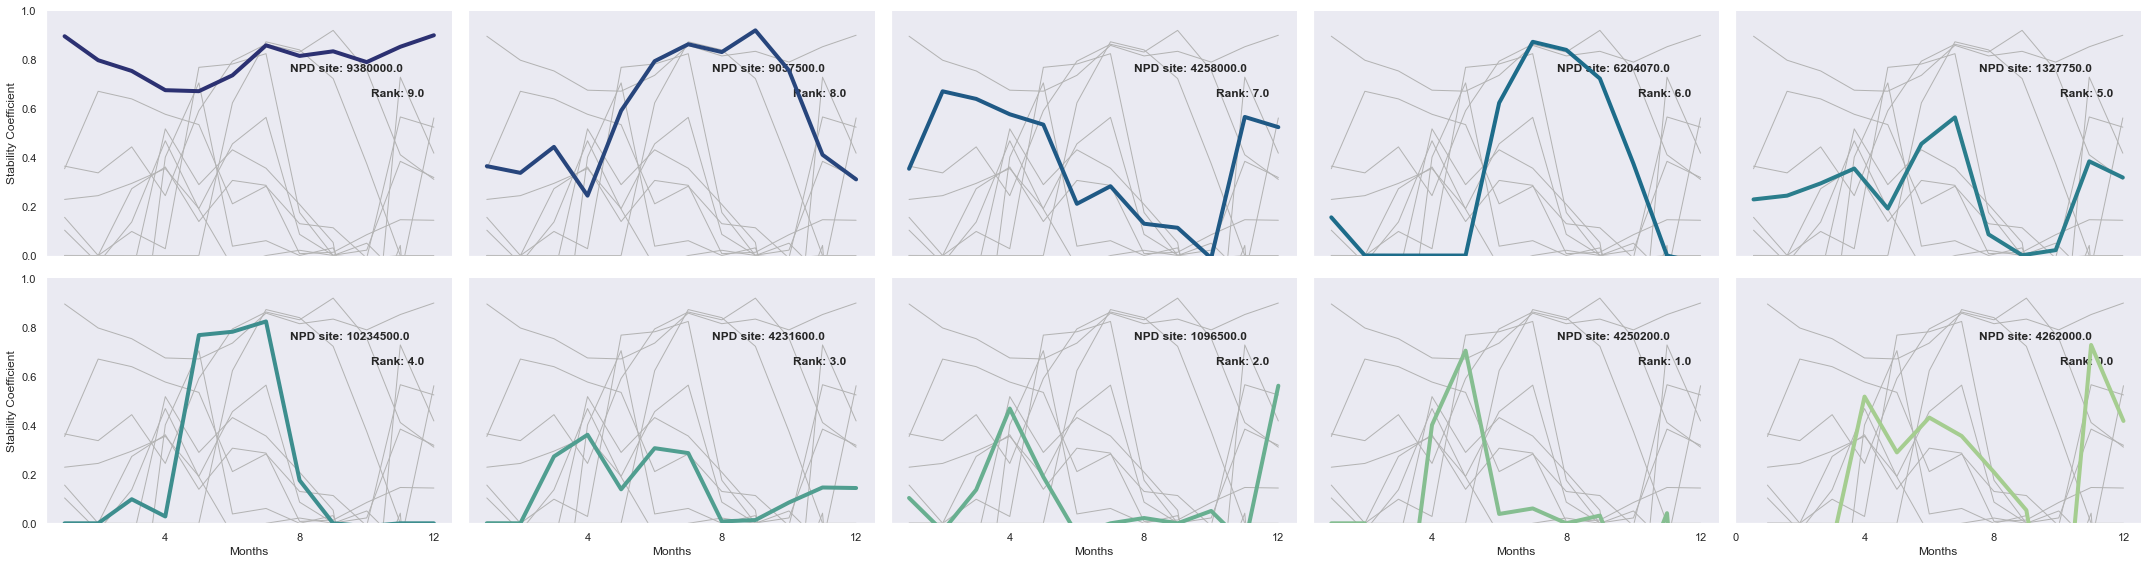

In [59]:
import seaborn as sns

#sns.set()
sns.set_theme(style="dark")
#sns.set_context("talk")
# Plot each year's time series in its own facet
g = sns.relplot(
    data=min_wind_hydro_plot_df,
    x="Month", y="c_stab", col="site_id", hue="rank",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for site, ax in g.axes_dict.items():
    
    # Add the title as an annotation within the plot
    ax.text(.6, .75, f"NPD site: {site}", transform=ax.transAxes, fontweight="bold")
    
    # Add the title as an annotation within the plot
    rank = min_plot_df["rank"].loc[min_plot_df.site_id == site].values[0]
    ax.text(.8, .65, f"Rank: {rank}", transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=min_plot_df, x="Month", y="c_stab", units="site_id",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.set_ylim([0,1])

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Months", "Stability Coefficient")
#g.fig.suptitle("The best NPDs for each decile")
g.tight_layout()
plt.savefig("ed_ranked_wind_hydro_deciles.eps")